***Participantes (RM - NOME):***<br>
339624 - Camila<br>
339656 - Cleiton<br>
340214 - Henrique<br>

## **Criar um classificador de sentimento aplicando técnicas de PLN**
---

Utilizando o dataset de revisões de filmes em português [1], criar um classificador de sentimentos que consiga um score na métrica F1 Score superior a 70%.

Devem utilizar uma amostra de 20% e randon_state igual a 42 para testar as implementações e mensurar a métrica F1 Score (usar o parâmetro average = 'weighted') o restante dos dados devem ser utilizados para o treinamento (80%).

Fique a vontade para testar os métodos de pré-processamento, abordagens, algoritmos e bibliotecas, mas explique e justifique suas decisões.
O trabalho poderá ser feito em grupo de até 4 pessoas (mesmo grupo do Startup One).

Separe a implementação do seu modelo campeão junto com a parte de validação/teste de forma que o professor consiga executar todo o pipeline do modelo campeão.

Composição da nota:
- 50% - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, etc.)
- 50% - Baseado na performance obtida com o dataset de teste (conforme recomendação da amostra) no seu modelo campeão e na validação que o professor processar (Métrica F1 Score).

[1] - https://dados-ml-pln.s3-sa-east-1.amazonaws.com/reviews-pt-br.csv

# Bibliotecas utilizadas

In [239]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import wordcloud as wd
import re
from collections import Counter

import spacy

import nltk
from nltk.stem.rslp import RSLPStemmer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint   
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, SpatialDropout1D, LSTM
from keras.layers import Dropout, Flatten, Conv1D, Embedding
from keras.layers import GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.convolutional import MaxPooling1D
import pydot


### carregando os modelos de lemmatização e stemização

In [2]:
sb.set_theme(context='notebook', style='whitegrid')

nlp = spacy.load('pt_core_news_md')
rslp = RSLPStemmer()

### checando se existe GPU disponível

In [3]:
print(tf.__version__)
#print(keras.__version__)
print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
True
Num GPUs Available:  1


# Funções Auxiliares

In [4]:
# função de Stemização completa do documento
def stemmer_text(frase):
  tokens = [rslp.stem(w) for w in frase.split()]
  return " ".join(tokens)

# função de lematização completa do documento
def lemmatizer_text(frase):
  doc = nlp(frase)
  tokens = [w.lemma_ for w in doc]
  return " ".join(tokens)

# função de lematização somente para os verbos do documento
def lemmatizer_verbs(frase):
  doc = nlp(frase)
  tokens = [w.lemma_ if w.pos_ == 'VERB' else w.text for w in doc]
  return " ".join(tokens)

# função de lematização apenas ADV e ADJ
def retirar_stop_words(frase):
  palavras = frase.split()
  palavras = [p.lower() for p in palavras if p not in stops]
  return " ".join(palavras) 

# função para retiral o plural das palavras em português
def plural_singular(palavra):
  r2 = r"ses$|zes$|res$"
  r3 = r"ões$|ães$"
  r4 = r"ais$|éis$|óis$|uis$"
  r5 = r"is$"
  r6 = r"eis$"
  if palavra.endswith('s'):
    if re.findall(r2, palavra):
      return palavra[:-2]
    if re.findall(r3, palavra):
      return palavra[:-3] + "ão"
    if re.findall(r4, palavra):
      return palavra[:-2] + "l"
    if re.findall(r5, palavra):
      return palavra[:-1] + "l"
    if re.findall(r6, palavra):
      return palavra[:-1] + "il"
    if palavra.endswith('ns'):
      return palavra[:-2] + "m"
    return palavra[:-1]
  return palavra  

# função para executar o pré processamento
def pre(frase):
  regex = r"[`,.?:;!&\"]"
  palavras = frase.split()
  palavras = [p.lower() for p in palavras if p not in stops]
  palavras = [re.sub(regex, "", p) for p in palavras]
  palavras = [p for p in palavras if len(p) >= 3]
  palavras = [p for p in palavras if not p.isnumeric()]
  palavras = [plural_singular(p) for p in palavras]

  return " ".join(palavras)

# função para criar as bases de treino e teste vetorizadas, com Unigramas, Bigramas e Trigramas
def criar_vetores(base_treino, base_teste, coluna):
    nomes = ['CV ngram(1,1)', 'CV ngram(1,2)', 'CV ngram(1,3)', 'CV ngram(2,2)', 'CV ngram(2,3)', 'CV ngram(3,3)',
                'TF ngram(1,1)', 'TF ngram(1,2)', 'TF ngram(1,3)', 'TF ngram(2,2)', 'TF ngram(2,3)', 'TF ngram(3,3)',]
    vetores = []
    idx = 0

    for x in range(1,4):
        for y in range(1,4): 
            if (y < x):
                continue
            vect = CountVectorizer(ngram_range=(x,y), stop_words = stops, min_df=10)
            vect.fit(df_treino[coluna])
            vect_treino = vect.transform(df_treino[coluna])
            vect_teste = vect.transform(df_teste[coluna])
            vetores.append([nomes[idx], vect_treino, vect_teste])
            idx += 1

    for x in range(1,4):
        for y in range(1,4): 
            if (y < x):
                continue
            vect = TfidfVectorizer(ngram_range=(x,y), stop_words = stops, min_df=10)
            vect.fit(df_treino['texto'])
            vect_treino = vect.transform(df_treino[coluna])
            vect_teste = vect.transform(df_teste[coluna])
            vetores.append([nomes[idx], vect_treino, vect_teste])
            idx += 1

    return vetores

def testar_modelo(modelo, base_treino, base_teste, vetores, coluna):
    f1score = 0
    nome = ""
    for x in vetores:
        modelo.fit(x[1], base_treino[coluna])
        predito = modelo.predict(x[2])
        f1 = f1_score(base_teste[coluna], predito, average='weighted')
        print(x[0], f1)
        if (f1score < f1):
            f1score = f1
            nome = x[0]

    return (nome, f1score)    

# Carregando os Dados

In [5]:
df = pd.read_csv('./data/reviews-pt-br.csv', encoding='utf-8')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44514 entries, 0 to 44513
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   codigo      44514 non-null  int64 
 1   texto       44514 non-null  object
 2   sentimento  44514 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [7]:
df.head(10)

,codigo,texto,sentimento
0,1,Esse bocejo de pia de cozinha de orçamento mui...,neg
1,2,O Bravo parece indicar que o personagem princi...,neg
2,3,"Durante a Guerra pela Independência do Sul, GE...",pos
3,4,É fora de questão que a verdadeira Anna Anders...,pos
4,5,Concordo totalmente com outro dos revisores aq...,neg
5,6,Obra-prima absoluta de um filme! Boa noite Mr....,pos
6,7,Embora a palavra megalmania seja muito usada p...,pos
7,8,Esta tem que ser a peça mais incrível de porca...,neg
8,9,Eu suponho que todas as piadas internas são o ...,neg
9,10,"Se há um tema deste filme, é que as pessoas po...",pos


## Conferindo se temos dados nulos ou duplicados

In [8]:
df.isna().sum()

codigo        0
texto         0
sentimento    0
dtype: int64

In [9]:
df[df.duplicated()].count()

codigo        0
texto         0
sentimento    0
dtype: int64

# Distribuição das respostas

Veremos abaixo que o nosso Dataset está quase perfeitamente distribuído entre amostras positivas e negativas.

In [10]:
df.groupby('sentimento').count()

,codigo,texto
sentimento,,
neg,22307,22307
pos,22207,22207


In [11]:
# em percentual
round(df.groupby('sentimento').count().texto / df.shape[0] * 100, 2)

sentimento
neg    50.11
pos    49.89
Name: texto, dtype: float64

<AxesSubplot:xlabel='sentimento', ylabel='count'>

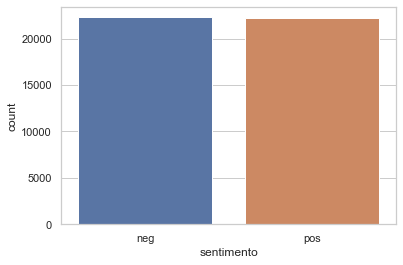

In [12]:
sb.countplot(x=df.sentimento)

# Criando o conjunto de stopwords (NLTK + SPACY)

In [13]:
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')
stopwords_spacy = nlp.Defaults.stop_words
stops = list(set(stopwords_spacy).union(stopwords_nltk))
print(sorted(stops))

['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'diante', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dão', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'en

# Analisando o conjunto total das palavras

In [14]:
# exemplo de críticas no nosso dataframe
print(df.texto[2])
print("-" * 40)
print(df.texto[1536])
print("-" * 40)
print(df.texto[8192])

Durante a Guerra pela Independência do Sul, GENERAL SPANKY mobiliza suas forças para defender as mulheres e crianças locais contra uma invasão dos Yankees. Em 1936, Hal Roach decidiu que era hora de seus populares garotos do OUR GANG se transformarem em filmes ocasionais. Com o grande sucesso de Shirley Temple em dois filmes do período da Guerra Civil em 1935, THE LITTLE COLONEL, THE LITTLEST REBEL, era natural que Roach olhasse na mesma direção para seu GANG. Apesar de ter uma produção bastante generosa e distribuída pela MGM, a GENERAL SPANKY não foi um sucesso crítico ou de bilheteria. Os pequenos GANGsters passariam a se dedicar a assuntos curtos. Embora ele tenha recebido o melhor faturamento e o papel principal, George McParland é rivalizado durante toda a primeira metade do filme pelo pequeno Billie Buckwheat Thomas. Aqui estavam dois dos melhores atores jovens que já apareceram nos filmes americanos. Com toda a experiência de profissionais experientes e antigos, estes dois gami

In [15]:
# criando um texto completo com todas as críticas
texto_completo = " ".join([texto for texto in df.texto])
texto_completo_pos = " ".join([texto for texto in df[df.sentimento == 'pos'].texto])
texto_completo_neg = " ".join([texto for texto in df[df.sentimento == 'neg'].texto])

In [16]:
print("QTD de todas as palvaras", len(texto_completo.split()))
print("QTD de todas as palvaras das críticas positivas", len(texto_completo_pos.split()))
print("QTD de todas as palvaras das críticas negativas", len(texto_completo_neg.split()))

QTD de todas as palvaras 9843831
QTD de todas as palvaras das críticas positivas 4923191
QTD de todas as palvaras das críticas negativas 4920640


Verificamos que mesmo no quesito de quantidade de palvras a divisão é quese perfeita entre negativos e positivos.

# Wordclouds

Vamos imprimir as Wordclouds para termos uma visualização dos nosso dados.

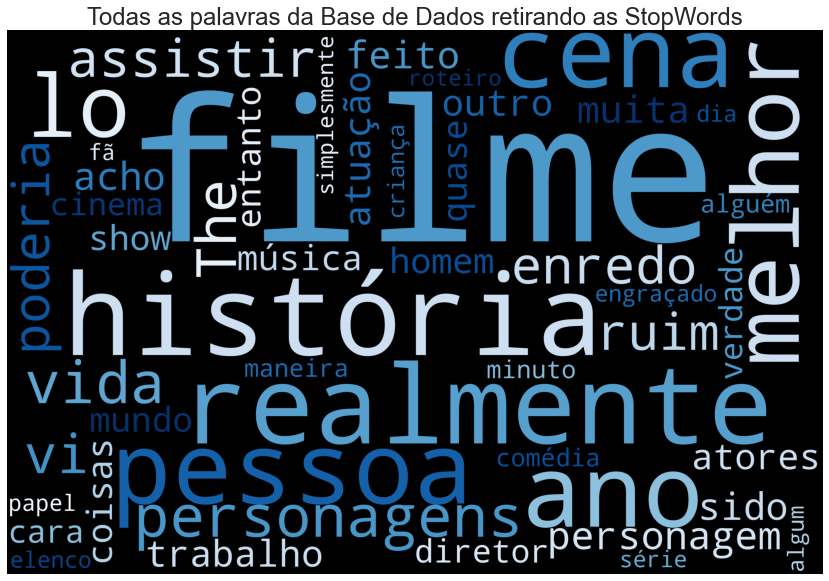

In [17]:
# criando uma wordcloud de todas as palavra sem as stopwords
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo)

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras da Base de Dados retirando as StopWords", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

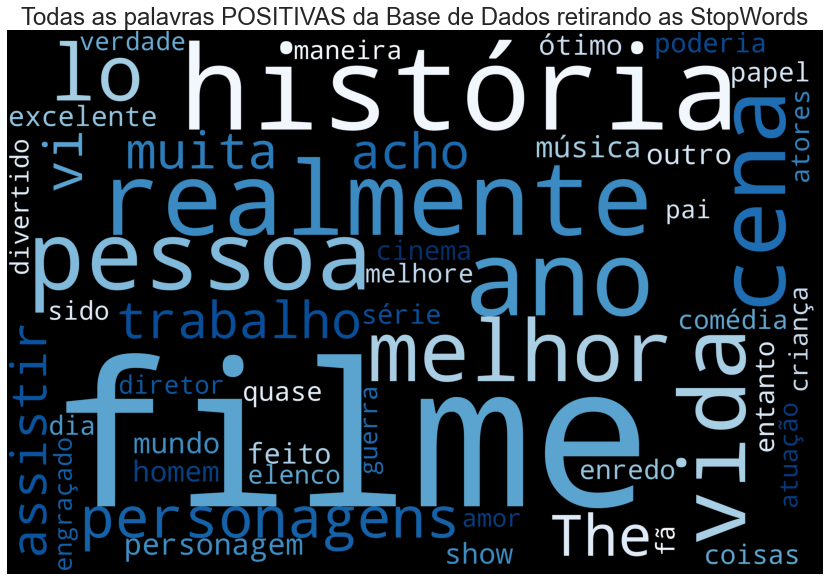

In [18]:
# criando uma wordcloud de todas as palavra da base positiva sem as stopwords
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo_pos)

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras POSITIVAS da Base de Dados retirando as StopWords", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

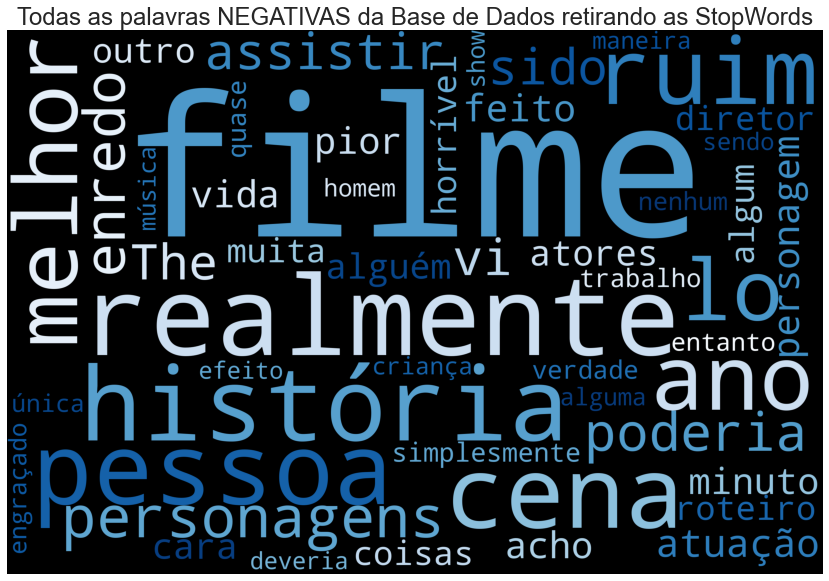

In [19]:
# criando uma wordcloud de todas as palavra da base negativa sem as stopwords
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo_neg)

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras NEGATIVAS da Base de Dados retirando as StopWords", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

# Criando uma função de pré processamento

Abaixo vamos criar um Pipeline que depois colocaremos em uma função para executar alguns procediemntos de pré processamento. Usaremos ela para teste, comparando com os modelos implementados nas bibliotecas e para treinar a nossa MLP.

In [20]:
palavras = texto_completo.split()
len(palavras)

9843831

In [21]:
# retirando as stopwords das palavras
palavras = [p.lower() for p in palavras if p not in stops]
len(palavras)

5057320

In [22]:
# retirando pontuações das palavras
regex = r"[`,.?:;!&\"]"
palavras = [re.sub(regex, "", p) for p in palavras]
len(palavras)

5057320

In [23]:
#retirando palavras menores que 3 caracteres
palavras = [p for p in palavras if len(p) >= 3]
len(palavras)

4646563

In [24]:
# retirando os números das palavras
palavras = [p for p in palavras if not p.isnumeric()]
len(palavras)

4632358

In [25]:
#convertendo as palavras para o singular
palavras = [plural_singular(p) for p in palavras]
len(palavras)

4632358

### Criamos uma função chamada "pre", na seção de funções auxiliares, que iremos usar em nossas análises dos modelos

## Wordcloud após o pré processamneto.

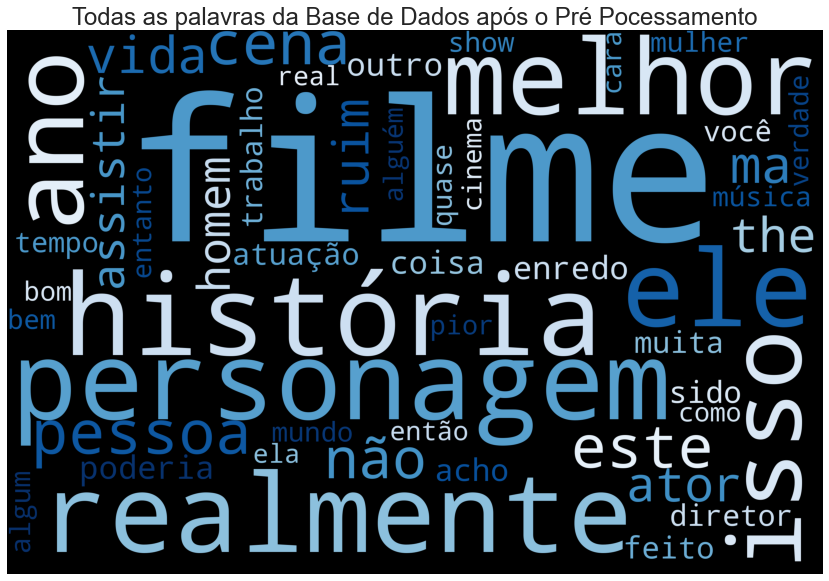

In [26]:
# criando uma wordcloud das palavras filtradas
ctp = Counter(palavras)
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False).fit_words(dict(ctp))

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras da Base de Dados após o Pré Pocessamento", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

# Vamos analisar quais palavras são comuns as críticas negativas e positivas

Iremos testar se retirando algumas delas o nosso modelo performa melhor.

In [27]:
todas_palavras_pos = texto_completo_pos.split()
todas_palavras_pos = [pre(w) for w in todas_palavras_pos]
todas_palavras_pos = [w for w in todas_palavras_pos if w != '']
ctpp = Counter(todas_palavras_pos)
ctpp.most_common(10)

[('filme', 79424),
 ('história', 13496),
 ('melhor', 11453),
 ('ele', 11133),
 ('personagem', 11108),
 ('ano', 10869),
 ('realmente', 10253),
 ('este', 9098),
 ('pessoa', 8975),
 ('cena', 8603)]

In [28]:
todas_palavras_neg = texto_completo_neg.split()
todas_palavras_neg = [pre(w) for w in todas_palavras_neg]
todas_palavras_neg = [w for w in todas_palavras_neg if w != '']
ctpn = Counter(todas_palavras_neg)
ctpn.most_common(10)

[('filme', 87835),
 ('realmente', 12175),
 ('personagem', 11443),
 ('isso', 11007),
 ('ruim', 10363),
 ('não', 10301),
 ('história', 10286),
 ('ele', 10202),
 ('cena', 9894),
 ('pessoa', 9889)]

In [40]:
%%time
p = dict(ctpp.most_common())
n = dict(ctpn.most_common())
palavras_comuns_neg_pos = [x for x in p if x in n]

Wall time: 127 ms


### quantidade de palavras comuns aos dois sentimentos.

In [41]:
len(palavras_comuns_neg_pos)

48663

### algumas palavras comuns aos dois.

In [328]:
palavras_comuns_neg_pos[:20]

['filme',
 'história',
 'melhor',
 'ele',
 'personagem',
 'ano',
 'realmente',
 'este',
 'pessoa',
 'cena',
 'vida',
 'isso',
 'ma',
 'the',
 'não',
 'homem',
 'ator',
 'outro',
 'trabalho',
 'muita']

## Criando as colunas tratadas

In [44]:
%%time
df['stem'] = df.texto.apply(stemmer_text)

Wall time: 7min 1s


In [45]:
%time
df['lemm'] = df.texto.apply(lemmatizer_text)

Wall time: 0 ns


In [46]:
%%time
df['verb'] = df.texto.apply(lemmatizer_verbs)

Wall time: 23min 40s


In [47]:
%%time
df['pre'] = df.texto.apply(pre)

Wall time: 55.6 s


In [48]:
%%time
df['stop'] = df.texto.apply(retirar_stop_words)

Wall time: 46 s


In [63]:
#df.to_csv("./data/criticas.csv")
df = pd.read_csv('./data/criticas.csv')
df = df.drop(['Unnamed: 0', 'codigo'], axis=1)

In [66]:
df.texto[4]

'Concordo totalmente com outro dos revisores aqui que ficou satisfeito "Para os Pássaros" ganhou o Oscar em 2002 por "Melhor Curta Animada", não este material doente, que é pretensioso na melhor das hipóteses e atraente para qualquer um, claro, que não tem crença no céu ou no inferno. A animação era boa, mas também há muitos curtas animados. E, a propósito, eu amo o humor negro, mas isso não foi nada atraente desde o início. Para a história aqui: um cara andando e cercado por nada além de simbolismo cinza é contado por um aparelho de TV que aparece a poucas centenas de metros de distância que ele está no céu, no inferno ou no purgatório. Cada vez que ele coloca uma arma na cabeça e atira depois de ouvir a notícia. Eu acho que seria engraçado em dois dos três casos.'

In [67]:
df.stop[4]

'concordo totalmente outro revisores ficou satisfeito "para pássaros" ganhou oscar 2002 "melhor curta animada", material doente, pretensioso melhor hipóteses atraente um, claro, crença céu inferno. a animação boa, curtas animados. e, propósito, amo humor negro, atraente início. para história aqui: cara andando cercado simbolismo cinza contado aparelho tv aparece poucas centenas metros distância céu, inferno purgatório. cada coloca arma cabeça atira ouvir notícia. eu acho engraçado casos.'

In [69]:
df.verb[4]

'Concordo totalmente com outro dos revisores aqui que ficar satisfeito " Para os Pássaros " ganhar o Oscar em 2002 por " Melhor Curta Animada " , não este material doente , que é pretensioso na melhor das hipóteses e atraente para qualquer um , claro , que não ter crença no céu ou no inferno . A animação era boa , mas também haver muitos curtas animar . E , a propósito , eu amar o humor negro , mas isso não foi nada atraente desde o início . Para a história aqui : um cara andar e cercar por nada além de simbolismo cinza é contar por um aparelho de TV que aparecer a poucas centenas de metros de distância que ele está no céu , no inferno ou no purgatório . Cada vez que ele colocar uma arma na cabeça e atirar depois de ouvir a notícia . Eu achar que seria engraçar em dois dos três casos .'

In [68]:
df.lemm[4]

'Concordo totalmente com outro dos revisor aqui que ficar satisfazer " Para o Pássaros " ganhar o Oscar em 2002 por " Melhor Curta Animada " , não este material doente , que ser pretensioso o melhor das hipótese e atraente parir qualquer um , claro , que não ter crença o céu ou o infernar . A animação ser bom , mas também haver muito curto animar . E , o propósito , eu amar o humor negro , mas isso não ser nado atraente desde o início . Para o história aqui : um caro andar e cercar por nado além de simbolismo cinzar ser contar por um aparelhar de TV que aparecer o pouco centena de metro de distância que ele estar o céu , o infernar ou o purgatório . Cada vez que ele colocar umar armar o cabeça e atirar depois de ouvir o notícia . Eu achar que seriar engraçar em dois dos três caso .'

In [70]:
df.stem[4]

'concord total com outr do revi aqu que fic satisfeit "p os pássaros" ganh o osc em 2002 por "melh curt animada", não est mater doente, que é pretensi na melhor da hipótes e atra par qualqu um, claro, que não tem crenç no céu ou no inferno. a anim era boa, mas também há muit curt animados. e, a propósito, eu amo o hum negro, mas iss não foi nad atra desd o início. par a histór aqui: um car and e cerc por nad além de simbol cinz é cont por um aparelh de tv que aparec a pouc centen de metr de dist que ele est no céu, no infern ou no purgatório. cad vez que ele coloc uma arm na cabeç e atir depois de ouv a notícia. eu ach que ser engraç em doi do trê casos.'

In [71]:
df.pre[4]

'concordo totalmente outro revisor ficou satisfeito para pássaro ganhou oscar melhor curta animada material doente pretensioso melhor hipótes atraente claro crença céu inferno animação boa curta animado propósito amo humor negro atraente início para história aqui cara andando cercado simbolismo cinza contado aparelho aparece pouca centena metro distância céu inferno purgatório cada coloca arma cabeça atira ouvir notícia acho engraçado caso'

In [72]:
df.head(10)

,texto,sentimento,stem,lemm,verb,pre,stop
0,Esse bocejo de pia de cozinha de orçamento mui...,neg,ess bocej de pia de co de orç muit baix é o ti...,Esse bocejar de pio de cozinhar de orçamentar ...,Esse bocejo de pia de cozinha de orçamento mui...,esse bocejo pia cozinha orçamento filme feito ...,esse bocejo pia cozinha orçamento filme feito ...
1,O Bravo parece indicar que o personagem princi...,neg,"o brav parec indic que o person principal, cla...",O Bravo parecer indicar que o personagem princ...,O Bravo parecer indicar que o personagem princ...,bravo indicar personagem principal claro coraj...,"o bravo indicar personagem principal, claro, c..."
2,"Durante a Guerra pela Independência do Sul, GE...",pos,"dur a guerr pel independ do sul, gener spanky ...","Durante o Guerra pelar Independência do Sul , ...","Durante a Guerra pela Independência do Sul , G...",durante guerra independência sul general spank...,"durante guerra independência sul, general span..."
3,É fora de questão que a verdadeira Anna Anders...,pos,é for de quest que a verd ann anderson não era...,É ser de questão que o verdadeiro Anna Anderso...,É fora de questão que a verdadeira Anna Anders...,verdadeira anna anderson princesa anastasia al...,é verdadeira anna anderson princesa anastasia....
4,Concordo totalmente com outro dos revisores aq...,neg,concord total com outr do revi aqu que fic sat...,Concordo totalmente com outro dos revisor aqui...,Concordo totalmente com outro dos revisores aq...,concordo totalmente outro revisor ficou satisf...,concordo totalmente outro revisores ficou sati...
5,Obra-prima absoluta de um filme! Boa noite Mr....,pos,obra-pr absolut de um filme! boa noit mr.tom r...,Obra-prima absoluto de um filmar ! Boa noite M...,Obra-prima absoluta de um filme ! Boa noite Mr...,obra-prima absoluta filme boa noite mrtom rapi...,obra-prima absoluta filme! boa noite mr.tom ra...
6,Embora a palavra megalmania seja muito usada p...,pos,emb a palavr megalman sej muit us par descrev ...,Embora o palavra megalmania ser muito usar par...,Embora a palavra megalmania seja muito usar pa...,embora palavra megalmania usada descrever gene...,embora palavra megalmania usada descrever gene...
7,Esta tem que ser a peça mais incrível de porca...,neg,est tem que ser a peç mais incr de porc cinema...,Esta ter que ser o pedir mais incrível de porc...,Esta tem que ser a peça mais incrível de porca...,esta peça incrível porcaria cinematográfica as...,esta peça incrível porcaria cinematográfica as...
8,Eu suponho que todas as piadas internas são o ...,neg,eu suponh que tod as pi intern são o que fez d...,Eu supor que todo o piar interno ser o que faz...,Eu supor que todas as piadas internas são o qu...,suponho piada interna munchie clássico cult pe...,eu suponho piadas internas munchies clássico c...
9,"Se há um tema deste filme, é que as pessoas po...",pos,"se há um tem dest filme, é que as pesso pod li...","Se haver um temer dar filmar , ser que o pesso...","Se haver um tema deste filme , ser que as pess...",tema filme pessoa lidar dificuldade imaginação...,"se tema filme, pessoas lidar dificuldades imag..."


# Dividindo a base em treino e teste

In [73]:
# dividindo com 20% para o treino e random state = 42
df_treino, df_teste = train_test_split(
      df, 
      test_size = 0.2, 
      random_state = 42
  )

In [74]:
# distribuição das respostas do treino em %
round(df_treino.groupby('sentimento').count() / df.shape[0] * 100, 2).texto

sentimento
neg    40.07
pos    39.93
Name: texto, dtype: float64

In [75]:
# distribuição das respostas do teste em %
round(df_teste.groupby('sentimento').count() / df.shape[0] * 100, 2).texto

sentimento
neg    10.04
pos     9.96
Name: texto, dtype: float64

# Testando diversos modelos com a base total de palavras sem stopwords

## Criando os vetores com CountVectorizer e TfidfVectorizer

In [167]:
%%time
# criando os vetores para Unigramas, Bigramas, Trigramas com CountVectorizer e TfidfVectorizer
vetores = criar_vetores(df_treino, df_teste, 'texto')

Wall time: 5min 8s


## Testando diversos modelos com os vetores criados

In [77]:
%%time
# modelo Árvore de Decisão
modelo = DecisionTreeClassifier(random_state=42, max_depth=50)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Árvore de Decisão - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.7334065607517617
CV ngram(1,2) 0.7389972124839376
CV ngram(1,3) 0.7416456410429769
CV ngram(2,2) 0.6132194031871322
CV ngram(2,3) 0.6143754350124869
CV ngram(3,3) 0.440902916358259
TF ngram(1,1) 0.7242198298707084
TF ngram(1,2) 0.7260879021556159
TF ngram(1,3) 0.7269344378693082
TF ngram(2,2) 0.611408385276224
TF ngram(2,3) 0.6152997395176724
TF ngram(3,3) 0.4438377004527155

Árvore de Decisão - CV ngram(1,3) - F1 Score: 74.16%
Wall time: 3min 57s


In [78]:
%%time
# modelo Random Forest
modelo = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Random Forest - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8570091422646389
CV ngram(1,2) 0.8580194411160453
CV ngram(1,3) 0.8610559351736565
CV ngram(2,2) 0.7738974149816571
CV ngram(2,3) 0.7747957289121654
CV ngram(3,3) 0.5939805367253124
TF ngram(1,1) 0.8527194695341529
TF ngram(1,2) 0.8548498155717084
TF ngram(1,3) 0.8569934729963394
TF ngram(2,2) 0.7777573321458281
TF ngram(2,3) 0.7803476027605121
TF ngram(3,3) 0.5922386561501604

Random Forest - CV ngram(1,3) - F1 Score: 86.11%
Wall time: 6min 21s


In [79]:
%%time
# modelo AdaBoost
modelo = AdaBoostClassifier(n_estimators=100, random_state=42)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"AdaBoost - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8113072237344358
CV ngram(1,2) 0.8119893681619048
CV ngram(1,3) 0.8119893681619048
CV ngram(2,2) 0.6631463063565599
CV ngram(2,3) 0.6630078264083823
CV ngram(3,3) 0.46169500243275796
TF ngram(1,1) 0.8087066011318896
TF ngram(1,2) 0.8060494093349827
TF ngram(1,3) 0.8055787156701836
TF ngram(2,2) 0.668940166492079
TF ngram(2,3) 0.6717980213185778
TF ngram(3,3) 0.46618350077771004

AdaBoost - CV ngram(1,2) - F1 Score: 81.2%
Wall time: 3min 47s


In [80]:
%%time
# modelo Bagging Classifier
modelo = BaggingClassifier(n_estimators=20, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Bagging - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.7829529863109658
CV ngram(1,2) 0.7822625447604084
CV ngram(1,3) 0.7840829303681472
CV ngram(2,2) 0.7470878093253949
CV ngram(2,3) 0.7506578822171368
CV ngram(3,3) 0.5922569249811895
TF ngram(1,1) 0.7935963307402973
TF ngram(1,2) 0.787549924702114
TF ngram(1,3) 0.793389110907307
TF ngram(2,2) 0.749359985803243
TF ngram(2,3) 0.7512825374870906
TF ngram(3,3) 0.592533692930128

Bagging - TF ngram(1,1) - F1 Score: 79.36%
Wall time: 27min 21s


In [81]:
%%time
# modelo Extra Trees Regressor
modelo = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Extra Trees Regressor - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8708200533848273
CV ngram(1,2) 0.8759927433580862
CV ngram(1,3) 0.8758795252960768
CV ngram(2,2) 0.7811582020103887
CV ngram(2,3) 0.7781320574766459
CV ngram(3,3) 0.5925747779938603
TF ngram(1,1) 0.8709188943514428
TF ngram(1,2) 0.8750847464964969
TF ngram(1,3) 0.8756461176623055
TF ngram(2,2) 0.7963599859499786
TF ngram(2,3) 0.7935512034983379
TF ngram(3,3) 0.5923588709500518

Extra Trees Regressor - CV ngram(1,2) - F1 Score: 87.6%
Wall time: 9min 13s


In [82]:
%%time
# modelo Gradient Boosting
modelo = GradientBoostingClassifier(n_estimators=200, random_state=42)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Gradient Boosting - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8131037840926045
CV ngram(1,2) 0.8154661088177287
CV ngram(1,3) 0.8136564531371888
CV ngram(2,2) 0.703771331017916
CV ngram(2,3) 0.7053132711254233
CV ngram(3,3) 0.5000896766537951
TF ngram(1,1) 0.8132784816099118
TF ngram(1,2) 0.8164773941162936
TF ngram(1,3) 0.814008556621088
TF ngram(2,2) 0.7067345728742199
TF ngram(2,3) 0.7063127642730296
TF ngram(3,3) 0.500132627555598

Gradient Boosting - TF ngram(1,2) - F1 Score: 81.65%
Wall time: 13min 9s


In [172]:
%%time
# modelo Regressão Logística
modelo = LogisticRegression(solver='saga', max_iter=100, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Regressão Logística - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,1) 0.8775679406907851
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,2) 0.884757001714444
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,3) 0.8841959613753392
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached 

In [87]:
%%time
# modelo Passive Agressive
modelo = PassiveAggressiveClassifier(random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Passive Agressive - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8456691927963159
CV ngram(1,2) 0.8662239768753464
CV ngram(1,3) 0.8673472012508682
CV ngram(2,2) 0.7765912918116423
CV ngram(2,3) 0.7743456179758983
CV ngram(3,3) 0.5423155547597628
TF ngram(1,1) 0.8507237969132462
TF ngram(1,2) 0.8715043635253087
TF ngram(1,3) 0.8717270286280259
TF ngram(2,2) 0.7825432505960539
TF ngram(2,3) 0.7844517846905066
TF ngram(3,3) 0.5502119859308695

Passive Agressive - TF ngram(1,3) - F1 Score: 87.17%
Wall time: 3.63 s


In [88]:
%%time
# modelo Ridge
modelo = RidgeClassifier(solver='sparse_cg', random_state=42)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Ridge - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.7585067593071052
CV ngram(1,2) 0.7477234170084225
CV ngram(1,3) 0.7525534828089833
CV ngram(2,2) 0.7399582036362565
CV ngram(2,3) 0.7370462071476761
CV ngram(3,3) 0.5925886471995548
TF ngram(1,1) 0.8773200856296003
TF ngram(1,2) 0.8891242755320212
TF ngram(1,3) 0.8883345753860943
TF ngram(2,2) 0.8149814872678168
TF ngram(2,3) 0.8167834743557018
TF ngram(3,3) 0.595673890235394

Ridge - TF ngram(1,2) - F1 Score: 88.91%
Wall time: 23.9 s


In [89]:
%%time
# modelo SGD
modelo = SGDClassifier(random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SGD - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8548745222099186
CV ngram(1,2) 0.8677979087343012
CV ngram(1,3) 0.8672275315382145
CV ngram(2,2) 0.807559686093767
CV ngram(2,3) 0.8044276726022707
CV ngram(3,3) 0.5798838824002565
TF ngram(1,1) 0.8816760564524672
TF ngram(1,2) 0.8879717331315884
TF ngram(1,3) 0.8878598659072925
TF ngram(2,2) 0.8247457475321708
TF ngram(2,3) 0.8234283422807653
TF ngram(3,3) 0.5883600913938836

SGD - TF ngram(1,2) - F1 Score: 88.8%
Wall time: 2.88 s


In [90]:
%%time
# modelo Naive Bayes Bernoulli
modelo = BernoulliNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Bernoulli - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8561785530659148
CV ngram(1,2) 0.8746468123072807
CV ngram(1,3) 0.8753162962608646
CV ngram(2,2) 0.8410494096777025
CV ngram(2,3) 0.8381562881984885
CV ngram(3,3) 0.5979569271742787
TF ngram(1,1) 0.8561785530659148
TF ngram(1,2) 0.8746468123072807
TF ngram(1,3) 0.8753162962608646
TF ngram(2,2) 0.8410494096777025
TF ngram(2,3) 0.8381562881984885
TF ngram(3,3) 0.5979569271742787

Naive Bayes Bernoulli - CV ngram(1,3) - F1 Score: 87.53%
Wall time: 1.61 s


In [91]:
%%time
# modelo Naive Bayes Complement
modelo = ComplementNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Complement - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8541920098423615
CV ngram(1,2) 0.8710538417137474
CV ngram(1,3) 0.8718351898036343
CV ngram(2,2) 0.8401366622752207
CV ngram(2,3) 0.8396681025173632
CV ngram(3,3) 0.5734863253834386
TF ngram(1,1) 0.8618447927514207
TF ngram(1,2) 0.8746325936041583
TF ngram(1,3) 0.8748477005896964
TF ngram(2,2) 0.8393536418952174
TF ngram(2,3) 0.8395563782718626
TF ngram(3,3) 0.5747816408564258

Naive Bayes Complement - TF ngram(1,3) - F1 Score: 87.48%
Wall time: 1.43 s


In [92]:
%%time
# modelo Naive Bayes Multinomial
modelo = MultinomialNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Multinomial - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8540793419186162
CV ngram(1,2) 0.8710538417137474
CV ngram(1,3) 0.871723063743025
CV ngram(2,2) 0.8400257852209359
CV ngram(2,3) 0.8395563782718626
CV ngram(3,3) 0.5726916420207792
TF ngram(1,1) 0.8613950353813321
TF ngram(1,2) 0.8747465261210724
TF ngram(1,3) 0.8746261871797448
TF ngram(2,2) 0.839021536888149
TF ngram(2,3) 0.8397859898224573
TF ngram(3,3) 0.5748707653722428

Naive Bayes Multinomial - TF ngram(1,2) - F1 Score: 87.47%
Wall time: 1.5 s


In [94]:
%%time
# modelo Linear SVM
modelo = LinearSVC(random_state=42, max_iter=1000)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SVM Linear - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,1) 0.8427503134500534
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,2) 0.8593696786901172
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,3) 0.8592543708124906
CV ngram(2,2) 0.7835525602249629
CV ngram(2,3) 0.7817598993091702
CV ngram(3,3) 0.5928683562102969
TF ngram(1,1) 0.8785747941960814
TF ngram(1,2) 0.8899243167399011
TF ngram(1,3) 0.8908224226768418
TF ngram(2,2) 0.813766579137476

# Testando os modelos com a base stematizada sem stopwords

In [95]:
%%time
# criando os vetores para Unigramas, Bigramas, Trigramas com CountVectorizer e TfidfVectorizer
vetores = criar_vetores(df_treino, df_teste, 'stem')

Wall time: 4min 36s


## apenas modelos com mais de 85% no passo anterior e tempo inferior a 5 minutos

In [96]:
%%time
# modelo Regressão Logística
modelo = LogisticRegression(solver='saga', max_iter=100, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Regressão Logística - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,1) 0.8791362357639468
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,2) 0.8864390070167878
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,3) 0.8873359188698855
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached

In [97]:
%%time
# modelo Passive Agressive
modelo = PassiveAggressiveClassifier(random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Passive Agressive - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8447715624515739
CV ngram(1,2) 0.8720642271552428
CV ngram(1,3) 0.8737499306282133
CV ngram(2,2) 0.8154524423713615
CV ngram(2,3) 0.8211824042196831
CV ngram(3,3) 0.670711521878216
TF ngram(1,1) 0.7824273705555479
TF ngram(1,2) 0.7946762938640037
TF ngram(1,3) 0.7944521435751063
TF ngram(2,2) 0.594318686498427
TF ngram(2,3) 0.5929128015931685
TF ngram(3,3) 0.35665806113545495

Passive Agressive - CV ngram(1,3) - F1 Score: 87.37%
Wall time: 5.03 s


In [98]:
%%time
# modelo Ridge
modelo = RidgeClassifier(solver='sparse_cg', random_state=42)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Ridge - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.7800723288078767
CV ngram(1,2) 0.7776023312377306
CV ngram(1,3) 0.7891719816823664
CV ngram(2,2) 0.7305320606980007
CV ngram(2,3) 0.7366007736035252
CV ngram(3,3) 0.6931774787857015
TF ngram(1,1) 0.8310286072770471
TF ngram(1,2) 0.8360933383775296
TF ngram(1,3) 0.8357547960627466
TF ngram(2,2) 0.610473749539492
TF ngram(2,3) 0.6107622720271955
TF ngram(3,3) 0.3740804219182571

Ridge - TF ngram(1,2) - F1 Score: 83.61%
Wall time: 42.1 s


In [99]:
%%time
# modelo SGD
modelo = SGDClassifier(random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SGD - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8593501815753932
CV ngram(1,2) 0.8739129241828761
CV ngram(1,3) 0.8732718898722627
CV ngram(2,2) 0.816242022298419
CV ngram(2,3) 0.8228637616258457
CV ngram(3,3) 0.7094704488293562
TF ngram(1,1) 0.8164689388996369
TF ngram(1,2) 0.819060757664068
TF ngram(1,3) 0.8184998012692756
TF ngram(2,2) 0.612289585227973
TF ngram(2,3) 0.6125923903751722
TF ngram(3,3) 0.373464245097864

SGD - CV ngram(1,2) - F1 Score: 87.39%
Wall time: 3.15 s


In [100]:
%%time
# modelo Naive Bayes Bernoulli
modelo = BernoulliNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Bernoulli - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.853279813727806
CV ngram(1,2) 0.8726032412689158
CV ngram(1,3) 0.8748100562187059
CV ngram(2,2) 0.8460315157127096
CV ngram(2,3) 0.8445608675521092
CV ngram(3,3) 0.7242011371467321
TF ngram(1,1) 0.8198725818996544
TF ngram(1,2) 0.8152285233285822
TF ngram(1,3) 0.8152326385312899
TF ngram(2,2) 0.6169621086941445
TF ngram(2,3) 0.6161082603679379
TF ngram(3,3) 0.37557593287108426

Naive Bayes Bernoulli - CV ngram(1,3) - F1 Score: 87.48%
Wall time: 1.74 s


In [101]:
%%time
# modelo Naive Bayes Complement
modelo = ComplementNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Complement - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8475371319702153
CV ngram(1,2) 0.8686958159758584
CV ngram(1,3) 0.8714971557859723
CV ngram(2,2) 0.8591156073972187
CV ngram(2,3) 0.8594120043129988
CV ngram(3,3) 0.7150760022360954
TF ngram(1,1) 0.8136591938472498
TF ngram(1,2) 0.8143208959389149
TF ngram(1,3) 0.8145369026247485
TF ngram(2,2) 0.618029123817186
TF ngram(2,3) 0.6168547481595895
TF ngram(3,3) 0.37369042341230274

Naive Bayes Complement - CV ngram(1,3) - F1 Score: 87.15%
Wall time: 1.54 s


In [102]:
%%time
# modelo Naive Bayes Multinomial
modelo = MultinomialNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Multinomial - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8473112660817483
CV ngram(1,2) 0.868583560494826
CV ngram(1,3) 0.8714971557859723
CV ngram(2,2) 0.8590047111285145
CV ngram(2,3) 0.8595265442310434
CV ngram(3,3) 0.715056211064448
TF ngram(1,1) 0.8130790345962262
TF ngram(1,2) 0.8137398018967721
TF ngram(1,3) 0.8138439492218046
TF ngram(2,2) 0.6180576030656999
TF ngram(2,3) 0.617623906023027
TF ngram(3,3) 0.37369042341230274

Naive Bayes Multinomial - CV ngram(1,3) - F1 Score: 87.15%
Wall time: 1.51 s


In [103]:
%%time
# modelo Linear SVM
modelo = LinearSVC(random_state=42, max_iter=1000)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SVM Linear - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,1) 0.8427503015472957
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,2) 0.8681338243394326
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,3) 0.8676849865494912
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ng

# Testando os modelos com a base lematizada sem stopwords

In [104]:
%%time
# criando os vetores para Unigramas, Bigramas, Trigramas com CountVectorizer e TfidfVectorizer
vetores = criar_vetores(df_treino, df_teste, 'lemm')

Wall time: 4min 25s


## continuamos com os mesmos modelos da Stematização

In [105]:
%%time
# modelo Regressão Logística
modelo = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Regressão Logística - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,1) 0.871388712672154
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,2) 0.8831840902003822
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,3) 0.8838571020911938
CV ngram(2,2) 0.8256702193560315
CV ngram(2,3) 0.8261200186940448
CV ngram(3,3) 0.6730479197760227
TF ngram(1,1) 0.8775423544457769
TF ngram(1,2) 0.8792318425480409
TF ngram(1,3) 0.8786705037223337
TF ngram(2,2) 0.7

In [106]:
%%time
# modelo Passive Agressive
modelo = PassiveAggressiveClassifier(random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Passive Agressive - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8408389855380523
CV ngram(1,2) 0.8666747300463125
CV ngram(1,3) 0.8664500539380493
CV ngram(2,2) 0.8026515935821301
CV ngram(2,3) 0.8045589586950525
CV ngram(3,3) 0.6414821974069701
TF ngram(1,1) 0.8362152276889182
TF ngram(1,2) 0.8453316405746953
TF ngram(1,3) 0.8440970821790377
TF ngram(2,2) 0.7042333934504862
TF ngram(2,3) 0.7034864100161662
TF ngram(3,3) 0.426228830088564

Passive Agressive - CV ngram(1,2) - F1 Score: 86.67%
Wall time: 5.35 s


In [107]:
%%time
# modelo Ridge
modelo = RidgeClassifier(solver='sparse_cg', random_state=42)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Ridge - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.7930718870256565
CV ngram(1,2) 0.7563640573646133
CV ngram(1,3) 0.7627614477664536
CV ngram(2,2) 0.7099646734239303
CV ngram(2,3) 0.7109814167922218
CV ngram(3,3) 0.6578369862851161
TF ngram(1,1) 0.8750777970541831
TF ngram(1,2) 0.8778925056788156
TF ngram(1,3) 0.8777810502291562
TF ngram(2,2) 0.7345770756710226
TF ngram(2,3) 0.734707728277097
TF ngram(3,3) 0.4339715409253568

Ridge - TF ngram(1,2) - F1 Score: 87.79%
Wall time: 40.8 s


In [108]:
%%time
# modelo SGD
modelo = SGDClassifier(random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SGD - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8623617960213429
CV ngram(1,2) 0.871497372620912
CV ngram(1,3) 0.870374314193577
CV ngram(2,2) 0.8077055153414473
CV ngram(2,3) 0.8072390361561478
CV ngram(3,3) 0.6664971386701526
TF ngram(1,1) 0.8739266227935694
TF ngram(1,2) 0.877184658287689
TF ngram(1,3) 0.8775265394726719
TF ngram(2,2) 0.7332294758492905
TF ngram(2,3) 0.7321043365656521
TF ngram(3,3) 0.43024935042331097

SGD - TF ngram(1,3) - F1 Score: 87.75%
Wall time: 3.66 s


In [109]:
%%time
# modelo Naive Bayes Bernoulli
modelo = BernoulliNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Bernoulli - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8447624849630707
CV ngram(1,2) 0.8679099133392059
CV ngram(1,3) 0.8676851100781984
CV ngram(2,2) 0.8486296058287263
CV ngram(2,3) 0.8444070061166389
CV ngram(3,3) 0.6779522151235321
TF ngram(1,1) 0.8388849014361389
TF ngram(1,2) 0.8432095299986397
TF ngram(1,3) 0.8432077205217546
TF ngram(2,2) 0.7449479689390794
TF ngram(2,3) 0.7437976162984026
TF ngram(3,3) 0.4342236652287708

Naive Bayes Bernoulli - CV ngram(1,2) - F1 Score: 86.79%
Wall time: 1.81 s


In [110]:
%%time
# modelo Naive Bayes Complement
modelo = ComplementNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Complement - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8501206808852098
CV ngram(1,2) 0.8644278954564537
CV ngram(1,3) 0.8655506597041437
CV ngram(2,2) 0.849586365803061
CV ngram(2,3) 0.8468772105981207
CV ngram(3,3) 0.6716025539832963
TF ngram(1,1) 0.850040407437503
TF ngram(1,2) 0.8542037543227335
TF ngram(1,3) 0.8535288027251701
TF ngram(2,2) 0.7456897381922211
TF ngram(2,3) 0.7438856610224384
TF ngram(3,3) 0.43283308739509896

Naive Bayes Complement - CV ngram(1,3) - F1 Score: 86.56%
Wall time: 1.59 s


In [111]:
%%time
# modelo Naive Bayes Multinomial
modelo = MultinomialNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Multinomial - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8501206808852098
CV ngram(1,2) 0.8644278954564537
CV ngram(1,3) 0.8655506597041437
CV ngram(2,2) 0.849586365803061
CV ngram(2,3) 0.8471028331266741
CV ngram(3,3) 0.671337498542541
TF ngram(1,1) 0.8502613703817574
TF ngram(1,2) 0.8540894865264704
TF ngram(1,3) 0.8536393655701684
TF ngram(2,2) 0.745793668857829
TF ngram(2,3) 0.7442139392415841
TF ngram(3,3) 0.43283308739509896

Naive Bayes Multinomial - CV ngram(1,3) - F1 Score: 86.56%
Wall time: 1.71 s


In [112]:
%%time
# modelo Linear SVM
modelo = LinearSVC(random_state=42, max_iter=2000)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SVM Linear - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,1) 0.8398293437788718
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,2) 0.864315334254487
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,3) 0.8658884105520414
CV ngram(2,2) 0.7960214498114365
CV ngram(2,3) 0.7998407799606694
CV ngram(3,3) 0.6615620550736362
TF ngram(1,1) 0.8770001249107156
TF ngram(1,2) 0.8786852751069337
TF ngram(1,3) 0.8786869280902067
TF ngram(2,2) 0.7345770756710226

# Testando os modelos com a base Pré Processada

In [113]:
%%time
# criando os vetores para Unigramas, Bigramas, Trigramas com CountVectorizer e TfidfVectorizer
vetores = criar_vetores(df_treino, df_teste, 'pre')

Wall time: 3min 45s


## Vamos testar apenas os 5 melhores modelos até agora

In [114]:
%%time
# modelo Regressão Logística
modelo = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Regressão Logística - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,1) 0.8710502464216818
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,2) 0.8774559330914977
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,3) 0.8776816803324722
CV ngram(2,2) 0.8173581035263575
CV ngram(2,3) 0.8176989129450517
CV ngram(3,3) 0.5823323573969434
TF ngram(1,1) 0.8793422820203212
TF ngram(1,2) 0.8814828731267541
TF ngram(1,3) 0.8822675641302015
TF ngram(2,2) 0.

In [115]:
%%time
# modelo Naive Bayes Bernoulli
modelo = BernoulliNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Bernoulli - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8566230581640968
CV ngram(1,2) 0.872402934409747
CV ngram(1,3) 0.8731882368059104
CV ngram(2,2) 0.8376724046397828
CV ngram(2,3) 0.8341166119244173
CV ngram(3,3) 0.5800057220981744
TF ngram(1,1) 0.8548384097609529
TF ngram(1,2) 0.8703811139394094
TF ngram(1,3) 0.8707165710250357
TF ngram(2,2) 0.8315366363425195
TF ngram(2,3) 0.8285702947618924
TF ngram(3,3) 0.5490119257158181

Naive Bayes Bernoulli - CV ngram(1,3) - F1 Score: 87.32%
Wall time: 1.58 s


In [116]:
%%time
# modelo Naive Bayes Multinomial
modelo = MultinomialNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Multinomial - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8549689146984613
CV ngram(1,2) 0.871279720804199
CV ngram(1,3) 0.8706058252865331
CV ngram(2,2) 0.8393629612386887
CV ngram(2,3) 0.8381114215778313
CV ngram(3,3) 0.5669038489313839
TF ngram(1,1) 0.8572385781259917
TF ngram(1,2) 0.8692540765131808
TF ngram(1,3) 0.8693631510801997
TF ngram(2,2) 0.830718784892549
TF ngram(2,3) 0.8289155312346619
TF ngram(3,3) 0.5304598351357982

Naive Bayes Multinomial - CV ngram(1,2) - F1 Score: 87.13%
Wall time: 1.42 s


In [117]:
%%time
# modelo Linear SVM
modelo = LinearSVC(random_state=42, max_iter=2000)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SVM Linear - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,1) 0.8385940582663615
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,2) 0.8606092865148899
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,3) 0.8588115688380807
CV ngram(2,2) 0.7843429278714612
CV ngram(2,3) 0.7837810263079318
CV ngram(3,3) 0.5809716450216716
TF ngram(1,1) 0.8727269249102824
TF ngram(1,2) 0.8821718424393796
TF ngram(1,3) 0.8825077776359189
TF ngram(2,2) 0.807479618961343

In [118]:
%%time
# modelo Extra Trees Regressor
modelo = ExtraTreesClassifier(n_estimators=10, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Extra Trees Regressor - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.7827362022024903
CV ngram(1,2) 0.794385016507464
CV ngram(1,3) 0.8033245142824351
CV ngram(2,2) 0.7653240887046683
CV ngram(2,3) 0.764877172021529
CV ngram(3,3) 0.5780070063002626
TF ngram(1,1) 0.7766463143784735
TF ngram(1,2) 0.7856666198328363
TF ngram(1,3) 0.7923426912822693
TF ngram(2,2) 0.7649163990684286
TF ngram(2,3) 0.7667862363972517
TF ngram(3,3) 0.5462627972243446

Extra Trees Regressor - CV ngram(1,3) - F1 Score: 80.33%
Wall time: 35.9 s


# Testando os modelos com a base Lemmatizando apenas os verbos

In [119]:
%%time
# criando os vetores para Unigramas, Bigramas, Trigramas com CountVectorizer e TfidfVectorizer
vetores = criar_vetores(df_treino, df_teste, 'verb')

Wall time: 4min 10s


In [120]:
%%time
# modelo Regressão Logística
modelo = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Regressão Logística - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,1) 0.870153296431196
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,2) 0.8807144201214318
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
CV ngram(1,3) 0.8803775065185797
CV ngram(2,2) 0.8181405669162283
CV ngram(2,3) 0.816677177326182
CV ngram(3,3) 0.6083813643871504
TF ngram(1,1) 0.8815791618433787
TF ngram(1,2) 0.8833923011577803
TF ngram(1,3) 0.8840656758535709
TF ngram(2,2) 0.81

In [121]:
%%time
# modelo Naive Bayes Bernoulli
modelo = BernoulliNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Bernoulli - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8523465209719742
CV ngram(1,2) 0.8693658968702689
CV ngram(1,3) 0.8708181374622521
CV ngram(2,2) 0.8382154163101594
CV ngram(2,3) 0.8343883584984358
CV ngram(3,3) 0.6104436506306223
TF ngram(1,1) 0.8491853644511781
TF ngram(1,2) 0.8643153993036056
TF ngram(1,3) 0.8661130294291304
TF ngram(2,2) 0.8245641873793927
TF ngram(2,3) 0.823035042943178
TF ngram(3,3) 0.5549469693311997

Naive Bayes Bernoulli - CV ngram(1,3) - F1 Score: 87.08%
Wall time: 1.59 s


In [122]:
%%time
# modelo Naive Bayes Multinomial
modelo = MultinomialNB()

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Naive Bayes Multinomial - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8547519694104435
CV ngram(1,2) 0.8674575171183488
CV ngram(1,3) 0.8691380503682982
CV ngram(2,2) 0.8393507595582753
CV ngram(2,3) 0.83808436444916
CV ngram(3,3) 0.5821947914866082
TF ngram(1,1) 0.8562226506034619
TF ngram(1,2) 0.8685807584987018
TF ngram(1,3) 0.8675690392878072
TF ngram(2,2) 0.8261059209984754
TF ngram(2,3) 0.8217167619124149
TF ngram(3,3) 0.5321065959946548

Naive Bayes Multinomial - CV ngram(1,3) - F1 Score: 86.91%
Wall time: 1.37 s


In [123]:
%%time
# modelo Linear SVM
modelo = LinearSVC(random_state=42, max_iter=2000)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"SVM Linear - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,1) 0.8410647334175689
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,2) 0.860609381477054
C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
CV ngram(1,3) 0.8612832597208612
CV ngram(2,2) 0.7828827497851002
CV ngram(2,3) 0.7850171328747871
CV ngram(3,3) 0.6063563428006253
TF ngram(1,1) 0.8798012987840483
TF ngram(1,2) 0.884864722673612
TF ngram(1,3) 0.8844164904569981
TF ngram(2,2) 0.7996060470284906


In [124]:
%%time
# modelo Extra Trees Regressor
modelo = ExtraTreesClassifier(n_estimators=20, random_state=42, n_jobs=-1)

f1score = testar_modelo(modelo, df_treino, df_teste, vetores, 'sentimento')

print()
print(f"Extra Trees Regressor - {f1score[0]} - F1 Score: {round(f1score[1]*100,2)}%")

CV ngram(1,1) 0.8206323129981713
CV ngram(1,2) 0.8358892722027663
CV ngram(1,3) 0.8392513624566394
CV ngram(2,2) 0.7719570506569801
CV ngram(2,3) 0.7752217592590233
CV ngram(3,3) 0.6005473916262247
TF ngram(1,1) 0.8207255925203217
TF ngram(1,2) 0.8268384099628575
TF ngram(1,3) 0.8304706452942974
TF ngram(2,2) 0.7744291715602897
TF ngram(2,3) 0.7700497492243219
TF ngram(3,3) 0.5548242496040003

Extra Trees Regressor - CV ngram(1,3) - F1 Score: 83.93%
Wall time: 1min 8s


# TESTE FINAL DOS DOIS MELHORES MODELOS

In [227]:
%%time
vect = TfidfVectorizer(ngram_range=(1,3), stop_words=stops, min_df=10)
vect.fit(df_treino.texto)
vect_total = vect.transform(df.texto)
vect_treino = vect.transform(df_treino.texto)
vect_teste = vect.transform(df_teste.texto)

Wall time: 48.9 s


In [228]:
%%time
# treinamento do modelo
modelo = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1)
modelo.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste (textos vetorizados)
predicao = modelo.predict(vect_teste)

# mensuração do resultado por F1 Score
f1score = f1_score(df_teste.sentimento, predicao, average='weighted')

print()
print(f"Regressão Logística - TF (1,3) - F1 Score: {round(f1score*100,2)}%")


Regressão Logística - TF (1,3) - F1 Score: 88.9%
Wall time: 2.85 s


In [229]:
%%time
# treinamento do modelo
modelo = LinearSVC(random_state=42, max_iter=1000)
modelo.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste (textos vetorizados)
predicao = modelo.predict(vect_teste)

# mensuração do resultado por F1 Score
f1score = f1_score(df_teste.sentimento, predicao, average='weighted')

print()
print(f"Regressão Logística - TF (1,3) - F1 Score: {round(f1score*100,2)}%")


Regressão Logística - TF (1,3) - F1 Score: 89.08%
Wall time: 528 ms


# Testando os melhores modelos, com a base completa, com KFold e CrossValidation

In [317]:
%%time
cv = KFold(n_splits=20, random_state=42, shuffle=True)

modelo = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1)

scores = cross_val_score(modelo, vect_total, df.sentimento, scoring='f1_weighted', cv=cv, n_jobs=-1)

print()
print(f"Regressão Logística - TF (1,3) - F1 Score: {round(np.mean(scores)*100,2)}%")


Regressão Logística - TF (1,3) - F1 Score: 89.14%
Wall time: 14 s


In [318]:
%%time
cv = KFold(n_splits=20, random_state=42, shuffle=True)

modelo = LinearSVC(random_state=42, max_iter=1000)

scores = cross_val_score(modelo, vect_total, df.sentimento, scoring='f1_weighted', cv=cv, n_jobs=-1)

print()
print(f"Regressão Logística - TF (1,3) - F1 Score: {round(np.mean(scores)*100,2)}%")


Regressão Logística - TF (1,3) - F1 Score: 89.01%
Wall time: 3.84 s


# Testando um modelo de MLP com a base pré processada

In [174]:
import gensim
from gensim.models import KeyedVectors

#model_cbow = KeyedVectors.load_word2vec_format('../codigo/cbow_s300.txt')

In [255]:
# função para plotar os gráficos de acurácia e perda

def plot_history(history):
    acc = history.history['get_f1']
    val_acc = history.history['val_get_f1']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training f1')
    plt.plot(x, val_acc, 'r', label='Validation f1')
    plt.title('Training and validation f1 score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [280]:
class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)

In [245]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [177]:
# base para o treino de MLP
df_mlp = df[['pre', 'stop']].copy()
df_mlp['target'] = [0 if x == 'neg' else 1 for x in df.sentimento]
df_mlp.head()

,pre,stop,target
0,esse bocejo pia cozinha orçamento filme feito ...,esse bocejo pia cozinha orçamento filme feito ...,0
1,bravo indicar personagem principal claro coraj...,"o bravo indicar personagem principal, claro, c...",0
2,durante guerra independência sul general spank...,"durante guerra independência sul, general span...",1
3,verdadeira anna anderson princesa anastasia al...,é verdadeira anna anderson princesa anastasia....,1
4,concordo totalmente outro revisor ficou satisf...,concordo totalmente outro revisores ficou sati...,0


In [178]:
# dividindo com 20% para o treino e random state = 42
df_treino_mlp, df_teste_mlp = train_test_split(
      df_mlp, 
      test_size = 0.2, 
      random_state = 42
  )
df_mlp.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44514 entries, 0 to 44513
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pre     44514 non-null  object
 1   stop    44514 non-null  object
 2   target  44514 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


## Criação dos vetores para treinar o modelo

In [179]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_treino_mlp.pre)

In [180]:
X_treino = tokenizer.texts_to_sequences(df_treino_mlp.pre)
X_teste = tokenizer.texts_to_sequences(df_teste_mlp.pre)

In [181]:
# vocabulário do treino
vocab_size = len(tokenizer.word_index) + 1
vocab_size

106704

In [182]:
print(df_treino_mlp.pre[2])
print(X_treino[2])

durante guerra independência sul general spanky mobiliza força defender mulher criança local invasão yankee hal roach decidiu hora popular garoto our gang transformarem filme ocasional com sucesso shirley temple filme período guerra civil the little colonel the littlest rebel natural roach olhasse mesma direção gang apesar produção generosa distribuída mgm general spanky sucesso crítico bilheteria pequeno gangster passariam dedicar assunto curto embora recebido melhor faturamento papel principal george mcparland rivalizado durante metade filme pequeno billie buckwheat thoma aqui melhor ator jovem apareceram filme americano com experiência profissional experiente antigo gamin podiam roubar cena coração bravata igual uma alegria constante nota falsa ele fornecem razão essencial assistir filme hoje phillip holme apresentação tranquila cavalheiresca protetor adulto spanky quase esquecido agora holme ótimo ator morreu cedo durante segunda guerra mundial genial ralph morgan especialmente sim

In [183]:
# tamanho do maior vetor na base de treino

max(len(x) for x in X_treino)

440

In [184]:
# normalizando o tamanho dos vetores para iniciar o treino

maxlen = 440

X_treino = pad_sequences(X_treino, padding='post', maxlen=maxlen)
X_teste = pad_sequences(X_teste, padding='post', maxlen=maxlen)

In [185]:
X_treino.shape

(35611, 440)

In [186]:
y_treino = df_treino_mlp.target.values.reshape(-1,1)
y_teste = df_teste_mlp.target.values.reshape(-1,1)
y_treino.shape

(35611, 1)

In [187]:
# função para usar o modelo pré treinado do C_BOW

def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))


    for word in word_index:
        if model_cbow.has_index_for(word):
            idx = word_index[word]
            vector = model_cbow.get_vector(word)
            embedding_matrix[idx] = np.array(
                vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [188]:
# Não utilizei pois não melhorou o modelo e demorava demais para processar
# embedding_matrix = create_embedding_matrix(tokenizer.word_index, 256)

## Criação do modelo de MLP

In [351]:
#Modelo da Rede MLP

model = Sequential()
#model.add(Embedding(input_dim=vocab_size, output_dim=256, weights=[embedding_matrix],  input_length=maxlen))
model.add(Embedding(input_dim=vocab_size, output_dim=300,  input_length=maxlen))
model.add(Dropout(0.5))
#model.add(Conv1D(32, 8, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
#model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [352]:
#Adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])

In [353]:
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 440, 300)          32011200  
_________________________________________________________________
dropout_29 (Dropout)         (None, 440, 300)          0         
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 300)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                19264     
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)              

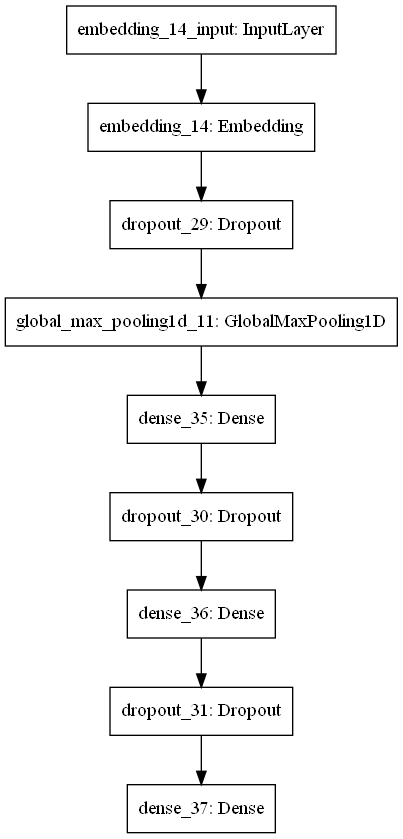

In [354]:
plot_model(model)

## Treinamento do modelo

In [356]:
%%time

checkpointer = ModelCheckpoint_tweaked(filepath='./modelo_mlp.hdf5', verbose=1,  save_best_only=True, mode='max', monitor='val_get_f1')

history  = model.fit(X_treino, y_treino, epochs=15, validation_data=(X_teste, y_teste), callbacks=[checkpointer], batch_size=1536)
#history  = model.fit(X_treino, y_treino, epochs=20, validation_split=0.2, callbacks=[checkpointer], batch_size=1024)

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.6276 - get_f1: 0.6330
Epoch 00001: val_get_f1 improved from -inf to 0.83810, saving model to .\modelo_mlp.hdf5
24/24 [==============================] - 23s 965ms/step - loss: 0.6689 - accuracy: 0.6276 - get_f1: 0.6330 - val_loss: 0.6460 - val_accuracy: 0.8450 - val_get_f1: 0.8381
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.8021 - get_f1: 0.8043
Epoch 00002: val_get_f1 improved from 0.83810 to 0.86018, saving model to .\modelo_mlp.hdf5
24/24 [==============================] - 25s 1s/step - loss: 0.5360 - accuracy: 0.8021 - get_f1: 0.8043 - val_loss: 0.4790 - val_accuracy: 0.8598 - val_get_f1: 0.8602
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8636 - get_f1: 0.8652
Epoch 00003: val_get_f1 improved from 0.86018 to 0.86836, saving model to .\modelo_mlp.hdf5
24/24 [==============================] - 25s 1s/step - lo

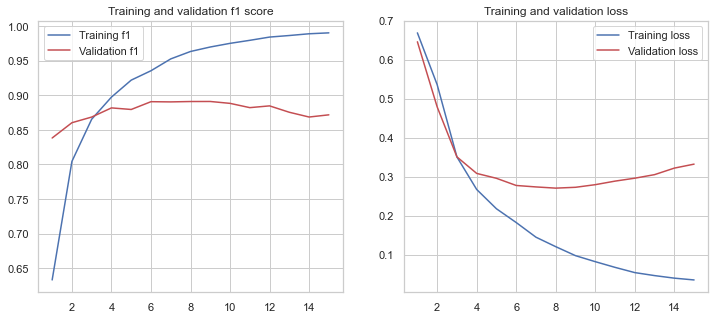

In [357]:
plot_history(history)

## carregando o melhor modelo salvo e testando nas bases de treino e teste

In [358]:
model = load_model("./modelo_mlp.hdf5", custom_objects={'get_f1': get_f1})

In [359]:
scores = model.evaluate(X_treino, y_treino)
print()
print(f"f1 score do Treino: {round(scores[2]*100,2)}%")

1113/1113 [==============================] - 6s 5ms/step - loss: 0.0923 - accuracy: 0.9879 - get_f1: 0.9874

f1 score do Treino: 98.74%


In [360]:
scores = model.evaluate(X_teste, y_teste)
print(f"f1 score da Validação: {round(scores[2]*100,2)}%")

279/279 [==============================] - 1s 5ms/step - loss: 0.2727 - accuracy: 0.8908 - get_f1: 0.8880
f1 score da Validação: 88.8%


# **Validação do professor**

Consolidar apenas os scripts do seu **modelo campeão**, desde o carregamento do dataframe, separação das amostras, tratamentos utilizados (funções, limpezas, etc.), criação dos objetos de vetorização dos textos e modelo treinado e outras implementações utilizadas no processo de desenvolvimento do modelo.

# Modelo Final

Após todos os testes acima decidimos que a REGRESSÃO LOGÍSTICA foi o melhor modelo, apesar de outros ficarem muito próximo dela.<BR/>
Ela teve o melhor resultado em diversos testes e no melhor teste ficou apenas 0,2% atrás da SVM, mas quando realizamos o teste de CROSS VALIDATION ela se saiu melhor. Por isso acreditamos que ela irá se sair melhor como modelo genérico.
O nosso teste de MLP se aproximou bastante do melhor resultado e acreditamos que com mais teste e ajustes pode se sair melhor que a Regressão Logística. Tentamos usar uma rede LSTM, que seria mais indicada, mas o treinamento demorou muito e acabamos usando uma rede MLP.

# Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import spacy

import nltk

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nlp = spacy.load('pt_core_news_sm')

# Carregando a Base de Dados

In [2]:
df = pd.read_csv('./data/reviews-pt-br.csv', encoding='utf-8')

# Dividindo em Treino e Teste

In [3]:
# dividindo com 20% para o treino e random state = 42
df_treino, df_teste = train_test_split(
      df, 
      test_size = 0.2, 
      random_state = 42
  )

# Criando o conjunto de Stop Words

In [4]:
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')
stopwords_spacy = nlp.Defaults.stop_words
stops = list(set(stopwords_spacy).union(stopwords_nltk))

# Criando os vetores com TF-IDF, de 1 a 3 gramas.

In [5]:
%%time
vect = TfidfVectorizer(ngram_range=(1,3), stop_words=stops, min_df=10)
vect.fit(df_treino.texto)
vect_total = vect.transform(df.texto)
vect_treino = vect.transform(df_treino.texto)
vect_teste = vect.transform(df_teste.texto)

Wall time: 49.9 s


# Treinando o modelo de Regresão Logística e verificando sua performance com a base de teino

In [6]:
%%time
# treinamento do modelo
modelo = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1)
modelo.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste (textos vetorizados)
predicao = modelo.predict(vect_teste)

# mensuração do resultado por F1 Score
f1score = f1_score(df_teste.sentimento, predicao, average='weighted')

print()
print(f"Regressão Logística - TF (1,3) - F1 Score: {round(f1score*100,2)}%")


Regressão Logística - TF (1,3) - F1 Score: 88.9%
Wall time: 4.02 s


# Executando a Cross Validation

In [7]:
%%time
cv = KFold(n_splits=20, random_state=42, shuffle=True)

modelo = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1)

scores = cross_val_score(modelo, vect_total, df.sentimento, scoring='f1_weighted', cv=cv, n_jobs=-1)

print()
print(f"Regressão Logística - TF (1,3) - F1 Score: {round(np.mean(scores)*100,2)}%")


Regressão Logística - TF (1,3) - F1 Score: 89.14%
Wall time: 14.5 s
